In [1]:
import numpy as np
import pandas as pd
import os
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import precision_recall_curve

import missingno as msno

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [117]:
df_survey = pd.read_csv('gates_data_csv/daily_surveys_onehot.csv')
df_baseline = pd.read_csv('gates_data_csv/baseline_screener_onehot.csv')
df_lab = pd.read_csv('gates_data_csv/lab_results_with_triggerdate.csv')
df_daily_activity = pd.read_csv('gates_data_csv/activity_daylvl.csv')

df_survey['timestamp'] = pd.to_datetime(df_survey.timestamp)
df_lab['trigger_datetime'] = pd.to_datetime(df_lab.trigger_datetime)

df_daily_activity.rename(columns = {'date':'timestamp'},inplace = True)
df_daily_activity['timestamp'] =  pd.to_datetime(df_daily_activity.timestamp).dt.date

/homes/gws/melih/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [118]:
df_lab_positive = df_lab.loc[df_lab.result == 'Detected'][['participant_id','trigger_datetime']]

In [119]:
# Adding flu positive information
df_survey = pd.merge(df_survey , df_lab_positive, how='left',on = 'participant_id')

In [120]:
# Strings in temp data, drop for now. Fill nan in recovered_yn and first_report_yn with zeros.
df_survey_model = df_survey.drop(columns = ['Unnamed: 0', 'occurrence', 'recovery_datetime', 'first_sx_datetime','body_temp_f'])
df_survey_model.fillna(value = {'recovered_yn': 0, 'first_report_yn': 0} ,inplace = True)
df_survey_model = df_survey_model.astype({'recovered_yn': 'int64','first_report_yn': 'int64'})
df_survey_model['missing_day'] = 0
df_survey_model.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527877 entries, 0 to 527876
Data columns (total 188 columns):
 #   Column                                         Dtype         
---  ------                                         -----         
 0   timestamp                                      datetime64[ns]
 1   participant_id                                 object        
 2   have_flu                                       int64         
 3   recovered_yn                                   int64         
 4   first_report_yn                                int64         
 5   t_recov_severity__q_recov_fever_0              int64         
 6   t_recov_severity__q_recov_fever_1              int64         
 7   t_recov_severity__q_recov_fever_2              int64         
 8   t_recov_severity__q_recov_fever_3              int64         
 9   t_recov_severity__q_recov_fever_skipped        int64         
 10  med_rx_name__4_0                               int64         
 11  med_rx_name_

<AxesSubplot:>

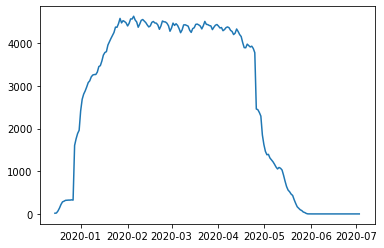

In [121]:
# No missingness in features if survey taken on a given day
# Number of survey datapoints per day (5.2k participants in total)
df_survey_model.timestamp.dt.date.value_counts().plot()

In [122]:
#Fill/mark missing survey days in between last and first day
missing_survey_rows = []

for participant in df_survey_model.participant_id.unique():
    date_vals = df_survey_model.loc[df_survey_model.participant_id == participant].timestamp.dt.date.values
    missing_dates = list(set(pd.date_range(date_vals.min(),date_vals.max()).date) - set(date_vals))
    
    for m_date in missing_dates:

        row_dict = dict.fromkeys(df_survey_model.columns,0)
        info_update = {'participant_id':participant, 'timestamp':m_date, 'trigger_datetime': None, 'missing_day': 1 }
        row_dict.update(info_update) 
        missing_survey_rows.append(row_dict)

df_survey_missing = pd.DataFrame(missing_survey_rows)               


In [211]:
#Fill/mark missing activity days in between last and first day

df_activity_model = df_daily_activity.drop(columns = ['Unnamed: 0', 'main_start_time'])

sleep_features = ['main_in_bed_minutes', 'main_efficiency','nap_count', 'total_asleep_minutes', 'total_in_bed_minutes']
step_features = ['activityCalories','caloriesOut', 'caloriesBMR', 'marginalCalories', 'sedentaryMinutes', 'lightlyActiveMinutes', 'fairlyActiveMinutes', 'veryActiveMinutes']

df_activity_model['missing_hr'] = 0
df_activity_model.loc[df_activity_model['resting_heart_rate'].isnull(), 'missing_hr'] = 1
df_activity_model.fillna(value = {'resting_heart_rate': 0}, inplace = True)

df_activity_model['missing_sleep'] = 0
df_activity_model.loc[df_activity_model['total_asleep_minutes'].isnull(), 'missing_sleep'] = 1

for feat in sleep_features:
    df_activity_model.fillna(value = {feat: 0}, inplace = True)
    
#step count derivatives
df_activity_model['missing_step'] = 0
df_activity_model.loc[df_activity_model['activityCalories'].isnull(), 'missing_step'] = 1

for feat in step_features:
    df_activity_model.fillna(value = {feat: 0}, inplace = True)

df_activity_model['missing_day'] = 0
missing_activity_rows = []

for participant in df_activity_model.participant_id.unique():
    date_vals = df_activity_model.loc[df_activity_model.participant_id == participant].timestamp.values
    missing_dates = list(set(pd.date_range(date_vals.min(),date_vals.max()).date) - set(date_vals))
    
    for m_date in missing_dates:

        row_dict = dict.fromkeys(df_activity_model.columns,0)
        info_update = {'participant_id':participant, 'timestamp':m_date, 'missing_day': 1 }
        row_dict.update(info_update) 
        missing_activity_rows.append(row_dict)

df_activity_missing = pd.DataFrame(missing_activity_rows) 


In [212]:
window_size = 15
total_min_days_with_data = window_size
max_missing_days_window = int(window_size * 0.3)


train_cut_off_date = datetime.datetime.strptime('2020-2-01', '%Y-%m-%d')
valid_cut_off_date = datetime.datetime.strptime('2020-2-10', '%Y-%m-%d')


#Append dummy days
df_survey_model_ms_filled = df_survey_model.append(df_survey_missing)
df_survey_model_ms_filled.sort_values(by = ['timestamp'], inplace = True)

df_activity_model_ms_filled = df_activity_model.append(df_activity_missing)
df_activity_model_ms_filled.sort_values(by = ['timestamp'], inplace = True)

#List to iterate over
participant_list = df_survey_model_ms_filled.participant_id.unique()


In [214]:
#Iterate over participants, pick window if missing days no more than win_size/n, link participants data across survey - activity - baseline

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

train_baseline_index = []
train_survey_x = []
train_activity_x = []
train_y = []


validation_date_range = [d.date() for d in pd.date_range(train_cut_off_date, valid_cut_off_date - datetime.timedelta(days = 1))]

#Dictionary of lists, a list for every day which will be used to train and validate progressively
validation_survey_x = dict.fromkeys(validation_date_range,[])
validation_activity_x = dict.fromkeys(validation_date_range,[])
validation_baseline_index = dict.fromkeys(validation_date_range,[])
validation_y = dict.fromkeys(validation_date_range,[])


for participant in participant_list:
    df_survey_participant = df_survey_model_ms_filled.loc[df_survey_model_ms_filled.participant_id == participant].reset_index(drop = True)
    df_activity_participant = df_activity_model_ms_filled.loc[df_activity_model_ms_filled.participant_id == participant].reset_index(drop = True)
    
    if len(df_survey_participant) >= total_min_days_with_data and len(df_activity_participant) >= total_min_days_with_data:

            existing_dates = df_survey_participant.iloc[window_size-1:].loc[df_survey_participant.missing_day == 0].timestamp.values
            
            #flu negatives
            if df_survey_participant.trigger_datetime.isnull().min():
                training_dates = [date for date in existing_dates if date < train_cut_off_date]
                validation_dates = [date for date in existing_dates if date >= train_cut_off_date and date < valid_cut_off_date]
                
                for t_date in training_dates:
                    survey_target_index = df_survey_participant.loc[df_survey_participant.timestamp == t_date].index.values[0]
                    activity_target = df_activity_participant.loc[df_activity_participant.timestamp == t_date.date()]
                    
                    #check if day with survey has activity
                    if activity_target.empty != True:
                        activity_target_index = activity_target.index.values[0]
                        
                        #check if there are w_size # days of activity leading to the given day
                        if len(df_activity_participant.iloc[:activity_target_index+1]) >= window_size:
                            
                            activity_cropped = df_activity_participant.iloc[activity_target_index - window_size+1:activity_target_index+1]
                            survey_cropped = df_survey_participant.iloc[survey_target_index - window_size+1:survey_target_index+1]
                            
                            if survey_cropped.missing_day.sum() <= max_missing_days_window and activity_cropped.missing_day.sum() <= max_missing_days_window:

                                train_baseline_index += [participant]
                                train_survey_x.append(survey_cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                                train_activity_x.append(activity_cropped.drop(columns = ['participant_id','timestamp']).to_numpy())
        
                                train_y += [0]


                for v_date in validation_dates:
                            
                    survey_target_index = df_survey_participant.loc[df_survey_participant.timestamp == v_date].index.values[0]
                    activity_target = df_activity_participant.loc[df_activity_participant.timestamp == v_date.date()]
                    if activity_target.empty != True:
                        
                        activity_target_index = activity_target.index.values[0] 
                        
                        if len(df_activity_participant.iloc[:activity_target_index+1]) >= window_size:
                            
                            activity_cropped = df_activity_participant.iloc[activity_target_index - window_size+1:activity_target_index+1]
                            survey_cropped = df_survey_participant.iloc[survey_target_index - window_size+1:survey_target_index+1]

                            if survey_cropped.missing_day.sum() <= max_missing_days_window and activity_cropped.missing_day.sum() <= max_missing_days_window:

                                v_date = v_date.date()
                                validation_baseline_index[v_date] = validation_baseline_index[v_date] + [participant]
                                validation_survey_x[v_date] = validation_survey_x[v_date] + [survey_cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy()]
                                validation_activity_x[v_date] = validation_activity_x[v_date] + [activity_cropped.drop(columns = ['participant_id','timestamp']).to_numpy()]
                                validation_y[v_date]  = validation_y[v_date] + [0]                
            
            #flu positives
            else:
                trigger_date = df_survey_participant.trigger_datetime.iloc[0]
                training_dates = [date for date in existing_dates if date < train_cut_off_date and date <= trigger_date]
                validation_dates = [date for date in existing_dates if (date >= train_cut_off_date and date < valid_cut_off_date and date <= trigger_date)]

                for t_date in training_dates:
                    survey_target_index = df_survey_participant.loc[df_survey_participant.timestamp == t_date].index.values[0]
                    activity_target = df_activity_participant.loc[df_activity_participant.timestamp == t_date.date()]
                    
                    #check if day with survey has activity
                    if activity_target.empty != True:
                        activity_target_index = activity_target.index.values[0]
                        
                        #check if there are w_size # days of activity leading to the given day
                        if len(df_activity_participant.iloc[:activity_target_index+1]) >= window_size:
                            
                            activity_cropped = df_activity_participant.iloc[activity_target_index - window_size+1:activity_target_index+1]
                            survey_cropped = df_survey_participant.iloc[survey_target_index - window_size+1:survey_target_index+1]
                            
                            if survey_cropped.missing_day.sum() <= max_missing_days_window and activity_cropped.missing_day.sum() <= max_missing_days_window:

                                train_baseline_index += [participant]
                                train_survey_x.append(survey_cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                                train_activity_x.append(activity_cropped.drop(columns = ['participant_id','timestamp']).to_numpy())

                                if (survey_cropped.iloc[-1].trigger_datetime.date() - survey_cropped.iloc[-1].timestamp.date()).days == 0:
                                    train_y += [1]
                                else:
                                    train_y += [0]


                for v_date in validation_dates:
                    survey_target_index = df_survey_participant.loc[df_survey_participant.timestamp == v_date].index.values[0]
                    activity_target = df_activity_participant.loc[df_activity_participant.timestamp == v_date.date()]
                    
                    if activity_target.empty != True:
                        
                        activity_target_index = activity_target.index.values[0] 
                        
                        if len(df_activity_participant.iloc[:activity_target_index+1]) >= window_size:
                            
                            activity_cropped = df_activity_participant.iloc[activity_target_index - window_size+1:activity_target_index+1]
                            survey_cropped = df_survey_participant.iloc[survey_target_index - window_size+1:survey_target_index+1]

                            if survey_cropped.missing_day.sum() <= max_missing_days_window and activity_cropped.missing_day.sum() <= max_missing_days_window:

                                v_date = v_date.date()
                                validation_baseline_index[v_date] = validation_baseline_index[v_date] + [participant]
                                validation_survey_x[v_date] = validation_survey_x[v_date] + [survey_cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy()]
                                validation_activity_x[v_date] = validation_activity_x[v_date] + [activity_cropped.drop(columns = ['participant_id','timestamp']).to_numpy()]

                                if (survey_cropped.iloc[-1].trigger_datetime.date() - survey_cropped.iloc[-1].timestamp.date()).days == 0:
                                    validation_y[v_date] = validation_y[v_date] + [1]
                                else:
                                    validation_y[v_date]  = validation_y[v_date] + [0]                    

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 23:58:29
Current Time = 00:07:58


# Negative train samples
#Take crops of window size number of days which aren't necessarily consecutive
window_size = 15
train_cut_off_date = datetime.datetime.strptime('2020-2-01', '%Y-%m-%d')
valid_cut_off_date = datetime.datetime.strptime('2020-4-01', '%Y-%m-%d')


flu_negative_participants = df_survey_model.loc[df_survey_model.trigger_datetime.isnull()].sort_values('timestamp')

train_flu_negative_participants = flu_negative_participants.loc[flu_negative_participants.timestamp < train_cut_off_date]

neg_train_samples = []

for participant in train_flu_negative_participants.participant_id.unique():
    train_participant = train_flu_negative_participants.loc[train_flu_negative_participants.participant_id == participant].drop(columns = ['participant_id','trigger_datetime','timestamp'])
        
    if len(train_participant) >= window_size:
        for train_i in range(0,len(train_participant) - window_size + 1):
            #if (train_participant.iloc[train_i+window_size-1].timestamp.date() - train_participant.iloc[train_i].timestamp.date()).days == (window_size-1):
            neg_train_samples.append(train_participant.iloc[train_i:train_i+window_size].to_numpy())

neg_train_y = len(neg_train_samples) * [0]

#Flu positive train samples
#Only use up to trigger date. Take crops of window size number of days which aren't necessarily consecutive

flu_positive_participants = df_survey_model.loc[df_survey_model.trigger_datetime.notnull()].sort_values('timestamp')
train_flu_positive_participants = flu_positive_participants.loc[flu_positive_participants.timestamp < train_cut_off_date]

#Only using days up to the trigger date
train_flu_positive_participants = train_flu_positive_participants.loc[(train_flu_positive_participants.timestamp.dt.date - train_flu_positive_participants.trigger_datetime.dt.date).dt.days <= 0]

pos_train_samples = []
pos_train_y = []

for participant in train_flu_positive_participants.participant_id.unique():
    train_participant = train_flu_positive_participants.loc[train_flu_positive_participants.participant_id == participant]
    
    
    if len(train_participant) >= window_size:
        for train_i in range(0,len(train_participant) - window_size + 1):

            window_crop = train_participant.iloc[train_i:train_i+window_size]
            
            #y=1 if window ends with dx
            if (window_crop.iloc[window_size-1].trigger_datetime.date() - window_crop.iloc[window_size-1].timestamp.date()).days == 0:
                pos_train_samples.append(window_crop.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                pos_train_y += [1]
                break
            else:
                pos_train_samples.append(window_crop.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                pos_train_y += [0]                



#Negative window crops for validation.

#Select particip with data before valid_cut_off date
valid_flu_negative_participants = flu_negative_participants.loc[(flu_negative_participants.timestamp < valid_cut_off_date)]

valid_participant_list = valid_flu_negative_participants.loc[valid_flu_negative_participants.timestamp >= train_cut_off_date].participant_id.unique()


#Last day inclusive range
valid_date_range = pd.date_range(train_cut_off_date, valid_cut_off_date - datetime.timedelta(days = 1))

#List of lists, a list for every day which will be used to train and validate progressively
valid_samples = [[] for _ in valid_date_range]
valid_y = [[] for _ in valid_date_range]

#Iterate over participants
for participant in valid_participant_list:
    valid_participant = valid_flu_negative_participants.loc[valid_flu_negative_participants.participant_id == participant]
    valid_participant.reset_index(drop = True, inplace = True)
    
    #for each participant iterate over date range, find the index of given date and take -window_size
    for i in range(len(valid_date_range)):
        valid_date = valid_date_range[i]
        #find index of row with the given validation date
        date_index = valid_participant.index[valid_participant['timestamp'].dt.date == valid_date.date()]
        
        #if data for given day exists, take all leading days and crop a window
        if len(date_index) != 0:
            valid_crop = valid_participant.iloc[:date_index[0]+1]
            
            if len(valid_crop) >= window_size:
                valid_samples[i].append(valid_crop.iloc[-window_size:].drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                valid_y[i].append(0)
                
                
            

#Positive window crops for validation.

#Select particip with data before valid_cut_off date
valid_flu_positive_participants = flu_positive_participants.loc[(flu_positive_participants.timestamp < valid_cut_off_date)]

valid_participant_list = valid_flu_positive_participants.loc[(valid_flu_positive_participants.timestamp >= train_cut_off_date) & (valid_flu_positive_participants.trigger_datetime >= train_cut_off_date)].participant_id.unique()


#Iterate over participants
for participant in valid_participant_list:
    valid_participant = valid_flu_positive_participants.loc[valid_flu_positive_participants.participant_id == participant]
    valid_participant.reset_index(drop = True, inplace = True)
    
    #for each participant iterate over date range, find the index of given date and take -window_size
    for i in range(len(valid_date_range)):
        valid_date = valid_date_range[i]
        date_index = valid_participant.index[valid_participant['timestamp'].dt.date == valid_date.date()]
        
        #if data for given day exists, take all leading days and crop a window
        if len(date_index) != 0:
            valid_crop = valid_participant.iloc[:date_index[0]+1]
            
            if len(valid_crop) >= window_size:
                
                #y=1 if window ends with dx
                if (valid_date.date() - valid_crop.iloc[-1].trigger_datetime.date()).days == 0:
                    
                    valid_samples[i].append(valid_crop.iloc[-window_size:].drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                    valid_y[i].append(1)
                    break
                    
                else:
                    valid_samples[i].append(valid_crop.iloc[-window_size:].drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                    valid_y[i].append(0)
 

In [215]:
#Convert survey data to np arrays. Train valid already split temporally.
train_survey_x_stacked = np.stack((train_survey_x))
train_activity_x_stacked = np.stack((train_activity_x))

train_y  = np.array(train_y)

validation_y_list = []
validation_survey_x_list = []
validation_activity_x_list = []

for key in validation_survey_x.keys():
    validation_survey_x_list += [np.stack(validation_survey_x[key])]
    validation_activity_x_list += [np.stack(validation_activity_x[key])]    
    validation_y_list += [np.array(validation_y[key])]

In [216]:
#participant ids to indices to time series and baselines
train_b_ind = []
for p in train_baseline_index:
    train_b_ind += [df_baseline.loc[df_baseline.participant_id == p].index.values[0]]
    
valid_b_ind = []

for key in validation_baseline_index.keys():
    ind_for_day = []
    for p in validation_baseline_index[key]:
        ind_for_day += [df_baseline.loc[df_baseline.participant_id == p].index.values[0]]
    valid_b_ind += [ind_for_day]

In [217]:
#Baseline data prepared for modelling
baseline_array = df_baseline.drop(['participant_id','Unnamed: 0'],axis=1).to_numpy()

baseline_scaled = baseline_array
scaler = MinMaxScaler()
baseline_scaled = scaler.fit_transform(baseline_array)  

pca_var = 0.95
pca = PCA(pca_var)
pca.fit(baseline_scaled)
baseline_pca = pca.transform(baseline_scaled)

In [218]:
baseline_pca.shape

(5229, 136)

In [219]:
def create_model(model_type, n_timesteps, n_features):
    if model_type == 'cnn':
        model = keras.Sequential()
        model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'same' ,input_shape=(n_timesteps,n_features)))
        model.add(layers.BatchNormalization())
        #model.add(layers.MaxPooling1D(pool_size=2))

        model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu',padding = 'same'))
        model.add(layers.BatchNormalization())

        model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu',padding = 'same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        #pooling
        #dropout
        #batch training
        model.add(layers.GlobalAveragePooling1D())
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

        return model
    
    elif model_type == 'lstm':
        
        model = keras.Sequential()
        model.add(layers.LSTM(128, input_shape=(n_timesteps, n_features)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

        return model

In [220]:
#Scale survey and activity train data
n_timesteps_survey = train_survey_x_stacked.shape[1]
n_features_survey = train_survey_x_stacked.shape[2]

n_timesteps_activity = train_activity_x_stacked.shape[1]
n_features_activity = train_activity_x_stacked.shape[2]

X_train_survey = train_survey_x_stacked
y_train = train_y
X_train_scaled_survey = X_train_survey

X_train_activity = train_activity_x_stacked
X_train_scaled_activity = X_train_activity

survey_scalers = {}
for i in range(n_features_survey):
    survey_scalers[i] = MinMaxScaler()
    X_train_scaled_survey[:, :, i] = survey_scalers[i].fit_transform(X_train_survey[:, :, i]) 
    
activity_scalers = {}
for i in range(n_features_activity):
    activity_scalers[i] = MinMaxScaler()
    X_train_scaled_activity[:, :, i] = activity_scalers[i].fit_transform(X_train_activity[:, :, i]) 

In [221]:
#Train survey based model to learn repr.
epochs = 10
model_type = 'lstm'
val_split = 0.15
minority_weight = len(y_train)/sum(y_train)

model_survey = create_model(model_type, n_timesteps_survey, n_features_survey)

shuffled_X_train, shuffled_y_train = shuffle(X_train_scaled_survey, y_train, random_state = 42)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

model_survey.fit(shuffled_X_train, shuffled_y_train, class_weight = {1: minority_weight, 0: 1}, epochs=epochs, validation_split=val_split, callbacks = [early_stopping_monitor], verbose=1)

Epoch 1/10
1590/1590 [==============================] - 11s 7ms/step - loss: 1.3350 - accuracy: 0.9166 - auc_14: 0.8394 - recall_14: 0.6522 - precision_14: 0.0035 - val_loss: 0.0509 - val_accuracy: 0.9871 - val_auc_14: 0.9962 - val_recall_14: 1.0000 - val_precision_14: 0.0333
Epoch 2/10
1590/1590 [==============================] - 10s 6ms/step - loss: 0.0514 - accuracy: 0.9885 - auc_14: 0.9990 - recall_14: 1.0000 - precision_14: 0.0380 - val_loss: 0.0229 - val_accuracy: 0.9938 - val_auc_14: 0.9972 - val_recall_14: 0.7500 - val_precision_14: 0.0517
Epoch 3/10
1590/1590 [==============================] - 10s 6ms/step - loss: 0.0293 - accuracy: 0.9941 - auc_14: 0.9991 - recall_14: 1.0000 - precision_14: 0.0712 - val_loss: 0.0136 - val_accuracy: 0.9967 - val_auc_14: 0.9956 - val_recall_14: 0.7500 - val_precision_14: 0.0938
Epoch 4/10
1590/1590 [==============================] - 10s 6ms/step - loss: 0.0387 - accuracy: 0.9950 - auc_14: 0.9990 - recall_14: 1.0000 - precision_14: 0.0824 - val_

In [224]:
#Train activity based model to learn repr.
model_activity  = create_model(model_type, n_timesteps_activity, n_features_activity)

shuffled_X_train, shuffled_y_train = shuffle(X_train_scaled_activity, y_train, random_state = 42)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

model_activity.fit(shuffled_X_train, shuffled_y_train, class_weight = {1: minority_weight, 0: 1}, epochs=epochs, validation_split=val_split, callbacks = [early_stopping_monitor], verbose=1)


Epoch 1/10
1590/1590 [==============================] - 10s 6ms/step - loss: 2.3252 - accuracy: 0.6252 - auc_17: 0.3996 - recall_17: 0.2609 - precision_17: 3.1491e-04 - val_loss: 0.6989 - val_accuracy: 0.1310 - val_auc_17: 0.7416 - val_recall_17: 1.0000 - val_precision_17: 5.1256e-04
Epoch 2/10
1590/1590 [==============================] - 10s 6ms/step - loss: 1.4067 - accuracy: 0.4977 - auc_17: 0.4559 - recall_17: 0.4348 - precision_17: 3.9145e-04 - val_loss: 0.6626 - val_accuracy: 0.8526 - val_auc_17: 0.7245 - val_recall_17: 0.5000 - val_precision_17: 0.0015
Epoch 3/10
1590/1590 [==============================] - 10s 6ms/step - loss: 1.4187 - accuracy: 0.5601 - auc_17: 0.5290 - recall_17: 0.4348 - precision_17: 4.4697e-04 - val_loss: 0.7526 - val_accuracy: 0.0852 - val_auc_17: 0.7340 - val_recall_17: 1.0000 - val_precision_17: 4.8691e-04
Epoch 4/10
1590/1590 [==============================] - 10s 6ms/step - loss: 1.3543 - accuracy: 0.4534 - auc_17: 0.6120 - recall_17: 0.6957 - precisi

In [226]:
#Get representations, mind the output layer
trained_survey_model = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[-2].output)
survey_representations = trained_survey_model(X_train_scaled_survey).numpy()

trained_activity_model = keras.Model(inputs=model_activity.input, outputs=model_activity.layers[-2].output)
activity_representations = trained_activity_model(X_train_scaled_activity).numpy()

#Scale survey representations
survey_rep_scaler = MinMaxScaler()
survey_representations_scaled = survey_rep_scaler.fit_transform(survey_representations)

activity_rep_scaler = MinMaxScaler()
activity_representations_scaled = activity_rep_scaler.fit_transform(activity_representations)

#(n of windows, features) array participant baselines corresponding to each time window
train_baseline = np.take(baseline_pca,train_b_ind,axis = 0)

#Combine survey and baseline data into a single array
train_combined = np.concatenate((activity_representations_scaled,survey_representations_scaled,train_baseline),axis = 1)



In [227]:
#Train end classifier
#rfc = RandomForestClassifier(n_estimators=100000,max_depth=10)
log = LogisticRegression(solver='lbfgs', class_weight='balanced',max_iter = 1000)
xgb_classif = xgb.XGBClassifier(scale_pos_weight = minority_weight, n_estimators=100, colsample_bytree = 0.3, learning_rate = 0.05,max_depth = 10, alpha = 10, verbosity = 0)

end_classifier = xgb_classif
end_classifier.fit(train_combined,y_train)



XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=2216.296296296296,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [231]:
#Train & valid loop
avg_survey_auc_preds = []
avg_survey_auc_prob = []

survey_TN = 0
survey_FN = 0
survey_TP = 0
survey_FP = 0

avg_activity_auc_preds = []
avg_activity_auc_prob = []

activity_TN = 0
activity_FN = 0
activity_TP = 0
activity_FP = 0

avg_combined_auc_preds = []
avg_combined_auc_prob = []

combined_TN = 0
combined_FN = 0
combined_TP = 0
combined_FP = 0

#Scaling issue!
survey_scalers = {}
for i in range(n_features_survey):
    survey_scalers[i] = MinMaxScaler()
    X_train_scaled_survey[:, :, i] = survey_scalers[i].fit_transform(X_train_survey[:, :, i]) 
    
activity_scalers = {}
for i in range(n_features_activity):
    activity_scalers[i] = MinMaxScaler()
    X_train_scaled_activity[:, :, i] = activity_scalers[i].fit_transform(X_train_activity[:, :, i]) 



for i in range(len(validation_survey_x_list)):
    
    #Predict
    daily_survey_batch_X = validation_survey_x_list[i]
    daily_activity_batch_X = validation_activity_x_list[i]    
    daily_batch_y = validation_y_list[i]
    
    scaled_daily_survey_batch_X = daily_survey_batch_X
    for feat in range(n_features_survey):
        scaled_daily_survey_batch_X[:, :, feat] = survey_scalers[feat].transform(daily_survey_batch_X[:, :, feat]) 

    scaled_daily_activity_batch_X = daily_activity_batch_X
    for feat in range(n_features_activity):
        scaled_daily_activity_batch_X[:, :, feat] = activity_scalers[feat].transform(daily_activity_batch_X[:, :, feat])
    
    #survey based predictions
    survey_preds = model_survey.predict_classes(scaled_daily_survey_batch_X, verbose=0)
    survey_prob = model_survey.predict(scaled_daily_survey_batch_X, verbose=0)
    
    roc_auc_preds = roc_auc_score(daily_batch_y,survey_preds)
    roc_auc_prob = roc_auc_score(daily_batch_y,survey_prob)
        
    avg_survey_auc_preds += [roc_auc_preds]
    avg_survey_auc_prob += [roc_auc_prob]
  
    survey_CM = confusion_matrix(daily_batch_y, survey_preds)

    survey_TN += survey_CM[0][0]
    survey_FN += survey_CM[1][0]
    survey_TP += survey_CM[1][1]
    survey_FP += survey_CM[0][1]

    print("survey pred based AUC: ", roc_auc_preds)
    print("survey proba based AUC: ", roc_auc_prob)
    print(survey_CM)
    
    #activity based predictions
    activity_preds = model_activity.predict_classes(scaled_daily_activity_batch_X, verbose=0)
    activity_prob = model_activity.predict(scaled_daily_activity_batch_X, verbose=0)
    
    roc_auc_preds = roc_auc_score(daily_batch_y,activity_preds)
    roc_auc_prob = roc_auc_score(daily_batch_y,activity_prob)
        
    avg_activity_auc_preds += [roc_auc_preds]
    avg_activity_auc_prob += [roc_auc_prob]
  
    activity_CM = confusion_matrix(daily_batch_y, activity_preds)

    activity_TN += activity_CM[0][0]
    activity_FN += activity_CM[1][0]
    activity_TP += activity_CM[1][1]
    activity_FP += activity_CM[0][1]

    print("activity pred based AUC: ", roc_auc_preds)
    print("activity proba based AUC: ", roc_auc_prob)
    print(activity_CM)

    
    
    #Get representations, mind the output layer
    survey_rep_model = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[-2].output)
    daily_survey_representations = survey_rep_model(scaled_daily_survey_batch_X).numpy()
    
    activity_rep_model = keras.Model(inputs=model_activity.input, outputs=model_activity.layers[-2].output)
    daily_activity_representations = activity_rep_model(scaled_daily_activity_batch_X).numpy()

    #Scaled representations
    daily_survey_representations_scaled = survey_rep_scaler.transform(daily_survey_representations)
    daily_activity_representations_scaled = activity_rep_scaler.transform(daily_activity_representations)


    #(n of windows, features) array participant baselines corresponding to each time window
    daily_baseline = np.take(baseline_pca,valid_b_ind[i],axis = 0)

    #Combine survey and baseline data into a single array
    daily_combined = np.concatenate((daily_activity_representations_scaled,daily_survey_representations_scaled,daily_baseline),axis = 1)
    
    #Classify
    combined_preds = end_classifier.predict(daily_combined)
    combined_prob = end_classifier.predict_proba(daily_combined)

    roc_auc_preds = roc_auc_score(daily_batch_y,combined_preds)
    roc_auc_prob = roc_auc_score(daily_batch_y,combined_prob[:,1])
 
    avg_combined_auc_preds += [roc_auc_preds]
    avg_combined_auc_prob += [roc_auc_prob]
   
    combined_CM = confusion_matrix(daily_batch_y, combined_preds)

    combined_TN += combined_CM[0][0]
    combined_FN += combined_CM[1][0]
    combined_TP += combined_CM[1][1]
    combined_FP += combined_CM[0][1]
   
    print("combined pred based AUC: ", roc_auc_preds)
    print("combined proba based AUC: ", roc_auc_prob)
    print(combined_CM) 
    
    #Train
    #X_train, y_train = shuffle(np.concatenate((X_train,daily_batch_X)), np.append(y_train,daily_batch_y), random_state = 42)
    
    """
    scalers = {}
    for j in range(n_features):
        scalers[j] = StandardScaler()
        scalers[j].fit(X_train[:, :, j]) 
        scaled_daily_batch_X[:, :, j] = scalers[j].transform(daily_batch_X[:, :, j])     
    """
    shuffled_X, shuffled_y= shuffle(scaled_daily_survey_batch_X, daily_batch_y, random_state = 42)
    model_survey.fit(shuffled_X, shuffled_y, class_weight = {1: minority_weight, 0: 1}, epochs=1, verbose=0)

    shuffled_X, shuffled_y= shuffle(scaled_daily_activity_batch_X, daily_batch_y, random_state = 42)
    model_activity.fit(shuffled_X, shuffled_y, class_weight = {1: minority_weight, 0: 1}, epochs=1, verbose=0)
    
    #Get representations, mind the output layer
    survey_rep_model = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[-2].output)
    daily_survey_representations = survey_rep_model(scaled_daily_survey_batch_X).numpy()
    
    activity_rep_model = keras.Model(inputs=model_activity.input, outputs=model_activity.layers[-2].output)
    daily_activity_representations = activity_rep_model(scaled_daily_activity_batch_X).numpy()

    #Scaled representations
    daily_survey_representations_scaled = survey_rep_scaler.transform(daily_survey_representations)
    daily_activity_representations_scaled = activity_rep_scaler.transform(daily_activity_representations)
    

    #Combine survey and baseline data into a single array
    daily_combined = np.concatenate((daily_activity_representations_scaled,daily_survey_representations_scaled,daily_baseline),axis = 1)
    
    #Train end-classif.
    end_classifier.fit(daily_combined, daily_batch_y)
'''#Train & valid loop
avg_survey_auc_preds = []
avg_survey_auc_prob = []

survey_TN = 0
survey_FN = 0
survey_TP = 0
survey_FP = 0

avg_activity_auc_preds = []
avg_activity_auc_prob = []

activity_TN = 0
activity_FN = 0
activity_TP = 0
activity_FP = 0

avg_combined_auc_preds = []
avg_combined_auc_prob = []

combined_TN = 0
combined_FN = 0
combined_TP = 0
combined_FP = 0'''

survey_acc = (survey_TP + survey_TN) / (survey_TP + survey_TN + survey_FP + survey_FN)
survey_precision = survey_TP/(survey_TP+survey_FP)
survey_recall = survey_TP/(survey_TP+survey_FN)
survey_f1_score = (2*survey_precision*survey_recall)/(survey_precision+survey_recall)

print("\n Average survey pred AUC: ", sum(avg_survey_auc_preds)/len(avg_survey_auc_preds))
print("\n Average survey prob AUC: ", sum(avg_survey_auc_prob)/len(avg_survey_auc_prob))

print("\n Overall survey accuracy: ", survey_acc)    
print("\n Overall survey precision: ", survey_precision)    
print("\n Overall survey recall: ", survey_recall)    
print("\n Overall survey f-1 score: ", survey_f1_score)   

activity_acc = (activity_TP + activity_TN) / (activity_TP + activity_TN + activity_FP + activity_FN)
activity_precision = activity_TP/(activity_TP+activity_FP)
activity_recall = activity_TP/(activity_TP+activity_FN)
activity_f1_score = (2*activity_precision*activity_recall)/(activity_precision+activity_recall)

print("\n Average activity pred AUC: ", sum(avg_activity_auc_preds)/len(avg_activity_auc_preds))
print("\n Average activity prob AUC: ", sum(avg_activity_auc_prob)/len(avg_activity_auc_prob))

print("\n Overall activity accuracy: ", activity_acc)    
print("\n Overall activity precision: ", activity_precision)    
print("\n Overall activity recall: ", activity_recall)    
print("\n Overall activity f-1 score: ", activity_f1_score) 

combined_acc = (combined_TP + combined_TN) / (combined_TP + combined_TN + combined_FP + combined_FN)
combined_precision = combined_TP/(combined_TP+combined_FP)
combined_recall = combined_TP/(combined_TP+combined_FN)
combined_f1_score = (2*combined_precision*combined_recall)/(combined_precision+combined_recall)

print("\n Average pred combined AUC: ", sum(avg_combined_auc_preds)/len(avg_combined_auc_preds))    
print("\n Average prob combined AUC: ", sum(avg_combined_auc_prob)/len(avg_combined_auc_prob))    

print("\n Overall combined accuracy: ", combined_acc)    
print("\n Overall combined precision: ", combined_precision)    
print("\n Overall combined recall: ", combined_recall)    
print("\n Overall combined f-1 score: ", combined_f1_score)    

print('\n Survey conf mat\n',survey_TN,'|',survey_FP,'\n',survey_FN,'|',survey_TP,'\n')
print('\n Activity conf mat\n',activity_TN,'|',activityy_FP,'\n',activity_FN,'|',activity_TP,'\n')
print('\n Combined conf mat\n',combined_TN,'|',combined_FP,'\n',combined_FN,'|',combined_TP,'\n')


survey pred based AUC:  0.6985628054038516
survey proba based AUC:  0.9977004886461627
[[3469   10]
 [   3    2]]
activity pred based AUC:  0.4931014659384881
activity proba based AUC:  0.6311008910606497
[[3431   48]
 [   5    0]]
combined pred based AUC:  0.6998562805403852
combined proba based AUC:  0.9937338315607933
[[3478    1]
 [   3    2]]
survey pred based AUC:  0.7465190754664439
survey proba based AUC:  0.9927596769702032
[[3566   25]
 [   1    1]]
activity pred based AUC:  0.7449874686716791
activity proba based AUC:  0.5346700083542189
[[3555   36]
 [   1    1]]
combined pred based AUC:  0.7491645781119466
combined proba based AUC:  0.7477722082985241
[[3585    6]
 [   1    1]]
survey pred based AUC:  0.6616312828887679
survey proba based AUC:  0.988205407367084
[[3637   37]
 [   2    1]]
activity pred based AUC:  0.4974142623843223
activity proba based AUC:  0.3478497550353838
[[3655   19]
 [   3    0]]
combined pred based AUC:  0.5
combined proba based AUC:  0.6608600979

NameError: name 'avg_auc_preds_combined' is not defined